# AI-driven Interactive Metadata 

*Amanda Birmingham, Dept. of Pediatrics, UC San Diego*

A natural-language approach to metadata investigation and cleaning using the `ChatGPT 4` LLM, the `Langchain` AI framework, AI-based speech recognition, and interactive `itables` visualization.

## Initial set-up

To be performed outside notebook:

In [1]:
!pip install pyaudio

## Adjustable LLM settings

In [2]:
import os

In [3]:
# Replace with your API keys
g_GEMINI = "<YOUR_GOOGLE_API_KEY>"
g_CHATGPT = os.environ['OPENAI_API_KEY']

g_chosen_llm = g_CHATGPT
g_MODEL = 'gpt-3.5-turbo'

In [4]:
# Do we want to enable voice recognition and speech? 
# This will activate the ability to use voice functions.
# This will display an additional button which will allow you to record.
g_use_speech = True

In [5]:
# WARNING: Increasing this number will increase the amount of information included in each 
# LLM query and thus increase the cost of the queries!
# Decreasing this number will make the LLM forget past exchanges more quickly
g_num_msgs_in_history = 4

In [6]:
g_base_prompt = f"using pandas 3 and python 3.10+ to clean data in jupyter lab."
g_ds_prompt = f"You are a data scientist {g_base_prompt}"
g_pf_prompt = f"You are a professor of data science teaching a class on {g_base_prompt}." 

## Imports

In [7]:
import os
import pandas as pd
import numpy as np
import re

In [8]:
import ipywidgets as widgets
from IPython import get_ipython
from IPython.display import display
from traitlets import observe, link, Unicode, Bool, Any
from itables import init_notebook_mode, show
from ipylab import JupyterFrontEnd
import time

In [9]:
import speech_recognition as speech_recog
import pyaudio

In [10]:
from langchain_core.messages import trim_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

from openai import OpenAI


In [11]:
import warnings
# warnings.filterwarnings('ignore')

In [12]:
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.WARNING, format='%(levelname)s: %(message)s')

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
import qiimp 

## Model creation

In [15]:
assert g_chosen_llm in list(dict(os.environ).values()), f"Please set the {g_chosen_llm} environment variable."

In [16]:
if g_chosen_llm == g_CHATGPT:
    from langchain_openai import ChatOpenAI
    _g_chat_model = ChatOpenAI(model="gpt-4o-mini")
elif g_chosen_llm == g_GEMINI:
    from langchain_google_genai import ChatGoogleGenerativeAI
    _g_chat_model = ChatGoogleGenerativeAI(
        model="gemini-1.5-pro",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
    )
else:
    raise ValueError(f"Unrecognized llm model '{g_chosen_llm}'")

## Chat creation

In [17]:
def _start_chat(model, custom_prompt):    
    # Define trimmer
    # count each message as 1 "token" (token_counter=len) and 
    #keep only the last x messages
    trimmer = trim_messages(strategy="last", max_tokens=g_num_msgs_in_history, 
                            token_counter=len)
    
    workflow = StateGraph(state_schema=MessagesState)
    
    # Define the function that calls the model
    def call_model(state: MessagesState):
        trimmed_messages = trimmer.invoke(state["messages"])
        system_prompt = custom_prompt
        messages = [SystemMessage(content=system_prompt)] + trimmed_messages
        response = model.invoke(messages)
        return {"messages": response}
    
    
    # Define the node and edge
    workflow.add_node("model", call_model)
    workflow.add_edge(START, "model")
    
    # Add simple in-memory checkpointer
    memory = MemorySaver()
    app = workflow.compile(checkpointer=memory)
    return app

In [18]:
_g_chat = _start_chat(_g_chat_model, g_ds_prompt)

## Front-end helpers

In [19]:
_g_front_end = JupyterFrontEnd()

In [20]:
def _insert_and_populate(statement=None, move_up=True):
    _g_front_end.commands.execute('notebook:insert-cell-below')
    if statement is not None:
        time.sleep(0.2)
        _g_front_end.commands.execute('notebook:replace-selection', { 'text': statement})
        _g_front_end.commands.execute('notebook:enter-edit-mode')

    if move_up:
        _g_front_end.commands.execute('notebook:move-cell-up') 
        

def _insert_and_run(statement=None, move_up=True):
    _insert_and_populate(statement, move_up)
    
    if statement is not None:
        _g_front_end.commands.execute('notebook:run-cell-and-select-next')  
        _g_front_end.commands.execute('notebook:enter-edit-mode')

def _insert_and_change_to_markdown(statement=None, move_up=True):
    _insert_and_run(statement, move_up)

In [20]:
# SLP = 2

# _g_front_end.commands.execute('notebook:run-cell-and-select-next')
# time.sleep(SLP)

# _g_front_end.commands.execute('notebook:run-cell')

# time.sleep(SLP)

# _g_front_end.commands.execute('notebook:enter-edit-mode')

# # cell_output = _oh[get_ipython().execution_count-1]
# # _g_front_end.commands.execute('notebook:move-cursor-up')
# _g_front_end.commands.execute('notebook:cut-cell')  
# time.sleep(SLP)

# _g_front_end.commands.execute('notebook:paste-cell-above')  
# time.sleep(SLP)

# _g_front_end.commands.execute('notebook:move-cursor-up')
# time.sleep(SLP)

# _g_front_end.commands.execute('notebook:change-cell-to-raw')
# time.sleep(SLP)


# _g_front_end.commands.execute('notebook:insert-cell-below')
# time.sleep(SLP)

# _g_front_end.commands.execute('notebook:replace-selection', { 'text': cell_output} )
# time.sleep(SLP)


# _g_front_end.commands.execute('notebook:change-cell-to-raw')
# time.sleep(SLP)

# _g_front_end.commands.execute('notebook:enter-edit-mode')
# time.sleep(SLP)

# # cell_output = _oh[get_ipython().execution_count-1]


### Prompt Engineering

In [21]:
# ai helper prompts
g_unique_set_prefix = "for column named"
g_col_check_prefix = "check column named"
g_code_prefix = "write code to"

# non-ai prompts
g_summarize_statement = "summarize table"

# button prompts
g_add_cell_statement = "add cell"
g_copy_last_statement = "copy it"
g_run_last_statement = "now run it"
g_revert_df_statement = "revert dataframe"

In [22]:
def _change_first_char(a_str, upper=True):
    if upper:
        a_lambda = lambda x: x.groups()[0].upper()
    else:
        a_lambda = lambda x: x.groups()[0].lower()
        
    # affect ONLY first letter, leave all the rest alone
    # (so different that a_str.capitialize() or a_str.title())
    return re.sub('([a-zA-Z])', a_lambda, a_str, 1)   


def _expand_prompt(user_prompt, df_name, a_df):
    df_prompt = f"You are given the '{df_name}' dataframe with columns {list(a_df.columns)}. "
    
    if user_prompt.startswith(g_col_check_prefix):
        col_name = user_prompt.replace(g_col_check_prefix, "").strip().replace(" ", "_")
        user_prompt = _get_explore_col_prompt(col_name)     
    # end if starts with check prefix--which itself adds a unique set prefix
    
    if user_prompt.startswith(g_unique_set_prefix):
        new_prompt = _get_unique_set_prompt(user_prompt, a_df)
    elif user_prompt.startswith(g_code_prefix):
        new_prompt = _get_code_prompt(user_prompt)        
    else:
        new_prompt = user_prompt

    new_prompt = df_prompt + new_prompt

    return new_prompt


def _get_explore_col_prompt(col_name):
    explore_prompt = "suggest the appropriate Pandas data type for the values in this column, very briefly hypothesize about what they represent, and indicate if any look invalid or unexpected." # Please keep responses short and to the point."
    col_prompt = f"{g_unique_set_prefix} {col_name}, {explore_prompt}"
    return col_prompt


def _get_unique_set_prompt(user_prompt, a_df):
    err_msg = f"Please phrase your question as {g_unique_set_prefix} <col_name>, <question about unique values of column>"
    
    if not user_prompt.startswith(g_unique_set_prefix):
        return err_msg

    prompt_split = user_prompt.split(",")
    if len(prompt_split) < 2:
        return err_msg

    col_name = prompt_split[0].replace(g_unique_set_prefix, "").strip()
    new_prompt = f"For the column named '{col_name}' containing the set of values  {set(a_df[col_name])}, {','.join(prompt_split[1:])}"
    return new_prompt


def _get_code_prompt(user_prompt):
    err_msg = f"Please phrase your question as {g_code_prefix} <perform some operation>"
    
    if not user_prompt.startswith(g_code_prefix):
        return err_msg

    new_prompt = f"{user_prompt} Do not include any non-comment explanations, import statements, or the instantiation of the dataframe. Do not include markdown formatting in your output. Provide runnable code as output."
    return new_prompt

## State management

In [23]:
_g_last_code_out = {}
_g_last_code_in = {}
_g_last_working_df = {}

In [24]:
_g_LAST_CODE_NAME = "AI-generated code"
_g_LAST_DF_NAME = "g_working_df"   


def _save_state(state_dict, obj_to_save, state_name, use_last_execution_num=False):
    # this does NOT copy the input obj_to_save before saving it--that should happen outside this call, if needed
    execution_num = get_ipython().execution_count
    if use_last_execution_num:
        execution_num = execution_num - 1
    
    if execution_num in state_dict:
        warnings.warn(f"{state_name} already contains state for a cell with execution number {execution_num}, which will be overwritten.")
    state_dict[execution_num] = obj_to_save
    return state_dict


def _get_last_state(state_dict):
    last_value = None
    if state_dict is not None and len(state_dict)>0:
        last_key, last_value = next(reversed(state_dict.items()))
    return last_value


def _df_changed():
    #print("in _df_changed")
    last_working_df = _get_last_state(_g_last_working_df)

    if last_working_df is not None:
        #print(f"g_working_df cols: {g_working_df.columns}")
        #print(f"last_working_df cols: {last_working_df.columns}")
        if not last_working_df.equals(g_working_df):
            #print("are different")
            return True
    return False


def _revert_df():
    global g_working_df
    msg = f"There is no {_g_LAST_DF_NAME} state stored." 

    last_working_df = _get_last_state(_g_last_working_df)
    if last_working_df is not None:
        if _df_changed():
            store_working_df()
            g_working_df = last_working_df
            msg = f"{_g_LAST_DF_NAME} reverted to last saved state."
        else:
            msg = f"{_g_LAST_DF_NAME} has not changed since last saved state."
    return msg


def store_working_df(a_df=None, use_last_execution_num=False):
    if a_df is None:
        a_df = g_working_df.copy()
    _save_state(_g_last_working_df, a_df, _g_LAST_DF_NAME, use_last_execution_num=use_last_execution_num)


def revert_df():
    statement = _revert_df()
    return statement


# decorator
def stateful(func):
    def wrapper(*args, **kwargs):
        if _df_changed():
            store_working_df(use_last_execution_num=True)
        func(*args, **kwargs) # No values returned in the wrapper
    return wrapper

# decorator with return value
def stateful_return(func):
    def wrapper(*args, **kwargs):
        if _df_changed():
            store_working_df(use_last_execution_num=True)
        return func(*args, **kwargs)  # Include return here
    return wrapper


## Chat helper function creation

In [25]:
# Instantiating an empty notebook allows prompt methods to bind to the 
# variable so the can use the real contents later without needing to be 
# passed an argument
g_working_df = pd.DataFrame()

In [26]:
def _summarize_col(col_name, a_df=None, max_items_shown=10):
    """ Returns list of lines. """
    
    a_df = a_df if a_df is not None else g_working_df
    
    lines = []
    lines.append(f"{col_name}")
    lines.append("================")
    a_col = a_df[col_name]
    
    summary = []
    col_uniques = a_col.unique()
    count_uniques = len(col_uniques)
    if a_col.is_unique:
        summary.append(f"All {count_uniques} values are unique.")
    else: 
        summary.append(f"There are {count_uniques} unique value(s) in {len(a_col)} total values.")
    # end if all are unique
        
    caveat = f"first {max_items_shown} " if count_uniques > max_items_shown else ""
    summary.append(f"The {caveat}unique value(s):{col_uniques[:max_items_shown]}.")
    lines.append(" ".join(summary))

    lines.append(f"The current datatype is {a_col.dtype}.")
    lines.append(" ")
    return lines


@stateful
def summarize_col(col_name, a_df=None, show_plot=True):
    
    stats, plot = stats_from_col(col_name, a_df)
    result = _summarize_col(col_name, a_df)
    result.extend(stats)
    result_str = "\n".join(result)
    print(result_str)
    if show_plot:
        plt.show()


@stateful
def summarize(a_df=None, max_items_shown=10, show_plot=False):
    a_df = a_df if a_df is not None else g_working_df
    
    result = [f"The dataframe has {len(a_df)} rows and {len(a_df.columns)} columns.", " "]
    for curr_col_name in a_df.columns:
        summarize_col(curr_col_name, a_df, show_plot=show_plot)
        # result.extend(curr_result)
        # print(curr_result)
        # if p is not None : plt.show()
    # next column
    # result_str = "\n".join(result)
    # print(result_str)


@stateful
def find_problem_headers(a_df=None):
    a_df = a_df if a_df is not None else g_working_df

    invalid_cols = a_df.columns[a_df.columns.str.contains(r'[^a-zA-Z0-9._ ]', regex=True)]
    if len(invalid_cols) == 0:
        out = "No invalid column headers found."
    else:
        out = invalid_cols
    print(out)


@stateful
def scrub_headers(a_df=None, lcase_headers=True):
    a_df = a_df if a_df is not None else g_working_df

    a_df.columns = a_df.columns.str.replace(r'[^a-zA-Z0-9]', '_', regex=True)  
    a_df.columns = a_df.columns.str.replace(r'__+', '_', regex=True)  
    a_df.columns = a_df.columns.str.strip('_')
    if lcase_headers:
        a_df.columns = a_df.columns.str.lower()
    print(a_df.columns)


@stateful
def find_problem_records(a_df=None):
    a_df = a_df if a_df is not None else g_working_df

    # get records with leading or trailing spaces in any field
    problem_records = a_df[a_df.apply(lambda x: x.str.contains(r'^\s|\s$', na=False).any(), axis=1)]
    if len(problem_records) == 0:
        print("No problem records found.")
    else:
        display(problem_records)
        return problem_records


@stateful
def scrub_problem_records():
    global g_working_df
    
    # Remove leading or trailing spaces from any field in the dataframe
    g_working_df = g_working_df.map(lambda x: x.strip() if isinstance(x, str) else x)
    print("Problem records scrubbed.")

## Summary stats (DANI)

In [27]:
def determine_col_type(col_name, a_df):
    
    # Ignore warnings generated by multiple calls to ask from the same cell
    warnings.filterwarnings('ignore')
    
    col = a_df[col_name]
    t = ask_return(f'based on the following entries: {col}, in a column named {col_name} is this categorical or numeric or identifier. Give a one word answer either categorical or numeric or identifier.')

    if 'identifier' in t.lower():
        return 'identifier'
    if 'categorical' in t.lower():
        return 'categorical'
    if 'numeric' in t.lower():
        return 'numeric'


def categorical_stats(col_name, a_df):
    """ Returns list of printable lines """

    col = a_df[col_name]
    counts = col.value_counts().to_string()

    lines = []
    lines.append(f'Column {col_name} thought to be categorical.')
    lines.append('------ Summary Statistics ------')
    lines.append(counts+'\n')
    
    return lines


def numeric_stats(col_name, a_df):
    """ Returns list of printable lines """

    # Drop nan values, coerce to numeric, then drop nans again
    col = a_df[col_name]
    new_col = pd.to_numeric(col.dropna(), errors='coerce')
    new_col = new_col.dropna()
    
    MIN = min(new_col)
    MAX = max(new_col)
    MED = np.median(new_col)
    
    lines = []
    lines.append(f'Column {col_name} thought to be numeric.')
    lines.append('------ Summary Statistics ------')
    lines.append(f'min: {MIN}\nmax: {MAX}\nmedian: {MED}\n')
    
    return lines

def id_stats(col_name, a_df):
    
    lines = [f'Column {col_name} thought to be identifier.\n']
    return lines
    

def stats_from_col(col_name, a_df=None, max_items_shown=10):
    """ Infers type of column then computes 
        summary statistics for the column. 
        Returns stats (list of lines - strings), plot. """

    a_df = a_df if a_df is not None else g_working_df

    type_of = determine_col_type(col_name, a_df)

    stats = [] # List of lines

    if type_of == 'categorical':
        stats += categorical_stats(col_name, a_df)
        plot = visualize_col_categorical(col_name, a_df)

    elif type_of == 'numeric':
        stats += numeric_stats(col_name, a_df)
        plot = visualize_col_numeric(col_name, a_df)

    elif type_of == 'identifier':
        stats += id_stats(col_name, a_df)
        plot = None

    stats.append('\n')

    return stats, plot

@stateful
def summarize_stats(a_df=None, max_items_shown=10):
    """ Infers all column types and reports summary statistics. """

    a_df = a_df if a_df is not None else g_working_df
    result = []
    for c in a_df.columns:
        curr_result = stats_from_col(c, a_df)
        result.extend(curr_result)
    result_str = '\n'.join(result)

    print(result_str)

    

## Visualizing metadata

In [28]:
def _explore_col(col_name, df_name=None, a_df=None):
    full_prompt = _get_explore_col_prompt(col_name)
    return _ask(full_prompt, df_name, a_df)


def visualize_col_categorical(col_name, df_name=None, a_df=None):
    """
    Generates a bar plot for the value counts of a specified column.

    Parameters:
        col_name (str): The column to group by.
        df_name (DataFrame): Name of dataframe if different than g_working_df.
        a_df (DataFrame): Dataframe if differnt than g_working_df
    """

    a_df = a_df if a_df is not None else g_working_df

    fig, ax = plt.subplots()
    sns.barplot(x=a_df[col_name].value_counts().index, 
                y=a_df[col_name].value_counts().values,
                ax=ax)
    ax.set_title(f"Value Counts for {col_name}")
    ax.set_ylabel("Counts")
    ax.set_xlabel(col_name)
    ax.tick_params(axis='x', rotation=45)  # Method 2: Directly rotate ticks

    return ax

def visualize_col_numeric(col_name, df_name=None, a_df=None):
    """
    Generates a bar plot for the value counts of a specified column.

    Parameters:
        col_name (str): The column to group by.
        df_name (DataFrame): Name of dataframe if different than g_working_df.
        a_df (DataFrame): Dataframe if differnt than g_working_df
    """

    a_df = a_df if a_df is not None else g_working_df

    df = a_df[[col_name]]
    df[col_name] = pd.to_numeric(df[col_name], errors='coerce')
    df = df.dropna()
    fig, ax = plt.subplots()
    sns.kdeplot(
       data=df, x=col_name,
       fill=True, common_norm=False,
       alpha=.5, linewidth=0, ax=ax
    )
    ax.set_title(f'{col_name}')
    return ax


def visualize_col(col_name, df_name=None, a_df=None):

    a_df = a_df if a_df is not None else g_working_df
    
    type_of = determine_col_type(col_name, a_df)

    if type_of == 'categorical':
        ax = visualize_col_categorical(col_name, a_df)
        plt.show()

    if type_of == 'numeric':
        ax = visualize_col_numeric(col_name, a_df)
        plt.show()

    if type_of == 'identifier':
        print(id_stats(col_name)[0])

def visualize_two_cols_cc(col_name1, col_name2, df_name=None, a_df=None):
    
    a_df = a_df if a_df is not None else g_working_df

    counts = a_df.groupby([col_name1, col_name2]).size().unstack(fill_value=0)
    fig, ax = plt.subplots()
    counts.plot(kind='bar', stacked=True, ax=ax)
    ax.set_xlabel(col_name1)
    ax.set_ylabel('Number of Observations')
    ax.set_title(f'Observations by {col_name1} and {col_name2}')
    ax.tick_params(axis='x', rotation=45)
    return ax


def visualize_two_cols_cn(cat_col, num_col, df_name=None, a_df=None):
    """
    Generates a histogram plot of the different values colored by category.
    """
    a_df = a_df if a_df is not None else g_working_df

    df = a_df[[num_col, cat_col]]
    df[num_col] = pd.to_numeric(df[num_col], errors='coerce')
    df[cat_col] = df[cat_col].astype('category')
    df = df.dropna()

    fig, ax = plt.subplots()
    sns.kdeplot(
       data=df, x=num_col, hue=cat_col,
       fill=True, common_norm=False,
       alpha=.5, linewidth=0, ax=ax
    )
    
    ax.set_title(f'{num_col} by {cat_col}')
    return ax


def visualize_two_cols_nn(col_name1, col_name2, df_name=None, a_df=None):
    """
    Generates a histogram plot of the different values colored by category.
    """
    a_df = a_df if a_df is not None else g_working_df

    df = a_df[[col_name1, col_name2]]
    df[col_name1] = pd.to_numeric(df[col_name1], errors='coerce')
    df[col_name2] = pd.to_numeric(df[col_name2], errors='coerce')
    df = df.dropna()
    fig, ax = plt.subplots()
    sns.scatterplot(
        data=df,
        x=col_name1,
        y=col_name2,
        ax=ax
    )
    ax.set_title(f'{col_name1} by {col_name2}')
    return ax


def visualize_two_cols(col_name1, col_name2, df_name=None, a_df=None):
    """
    Generates a stacked bar plot for the counts of two categorical columns.

    Parameters:
        col_name1 (str): The first column to group by.
        col_name2 (str): The second column to group by.
        df_name (DataFrame): Name of dataframe if different than g_working_df.
        a_df (DataFrame): Dataframe if differnt than g_working_df
    """

    a_df = a_df if a_df is not None else g_working_df

    type_of1 = determine_col_type(col_name1, a_df)
    type_of2 = determine_col_type(col_name2, a_df)
    print(f'Column {col_name1} thought to be {type_of1}.\nColumn {col_name2} thought to be {type_of2}.')

    if type_of1 == 'categorical' and type_of2 == 'categorical':
        visualize_two_cols_cc(col_name1, col_name2, a_df)
    elif type_of1 == 'categorical' and type_of2 == 'numeric':
        visualize_two_cols_cn(col_name1, col_name2, a_df)
    elif type_of1 == 'numeric' and type_of2 == 'categorical':
        visualize_two_cols_cn(col_name2, col_name1, a_df)
    elif type_of1 == 'numeric' and type_of2 == 'numeric':
        visualize_two_cols_nn(col_name1, col_name2, a_df)
    else:
        print('Invalid column types.')



## Asking a question and exploring a column

In [29]:
def _ask(user_prompt, df_name=None, a_df=None):
    df_name = df_name if df_name is not None else "g_working_df"
    a_df = a_df if a_df is not None else g_working_df
    
    new_prompt = _expand_prompt(user_prompt, df_name, a_df)    
    result = _g_chat.invoke(
        {"messages": [HumanMessage(content=new_prompt)]},
        config={"configurable": {"thread_id": "1"}},
    )
    return new_prompt, result


def _get_result_text(a_result):
    return a_result.get("messages")[-1].content


def _clean_answer(answer_str):
    answer_str = re.sub("^```python\n", "", answer_str)
    answer_str = re.sub("\n```$", "", answer_str)   
    return answer_str
    

def _explore_col(col_name, df_name=None, a_df=None):
    full_prompt = _get_explore_col_prompt(col_name)
    return _ask(full_prompt, df_name, a_df)


def _run_non_ai_prompts(user_prompt):
    ai_needed = False
    
    # Note, these have to be full prompts, not prompt prefixes
    if user_prompt == g_summarize_statement:
        summarize()
    else:
        ai_needed = True
    return ai_needed
    

@stateful
def explore_col(col_name, df_name=None, a_df=None):
    _, result = _explore_col(col_name, df_name, a_df)
    print(_get_result_text(result))


@stateful
def ask(user_prompt, df_name=None, a_df=None, show_prompt=False):  
    orig_prompt = user_prompt

    try:
        user_prompt = _change_first_char(user_prompt, upper=False)
        ai_needed = _run_non_ai_prompts(user_prompt)
    
        if ai_needed:
            # otherwise, ask AI
            prompt, result = _ask(user_prompt, df_name, a_df)  
            output = _get_result_text(result)
            output = _clean_answer(output)
        
            if show_prompt:
                output = prompt + "\n\n" + output

            last_input = _ih[get_ipython().execution_count]
            last_output = output
            
            _save_state(_g_last_code_out, last_output, _g_LAST_CODE_NAME)
            _save_state(_g_last_code_in, last_input, _g_LAST_CODE_NAME)
            print(output)

    #except Exception as ex:
    #    print(f"I don't understand the prompt:\n{orig_prompt}")
    finally:
        pass

    return output

@stateful_return
def ask_return(user_prompt, df_name=None, a_df=None, show_prompt=False):  
    orig_prompt = user_prompt

    try:
        user_prompt = _change_first_char(user_prompt, upper=False)
        ai_needed = _run_non_ai_prompts(user_prompt)
    
        if ai_needed:
            # otherwise, ask AI
            prompt, result = _ask(user_prompt, df_name, a_df)  
            output = _get_result_text(result)
            output = _clean_answer(output)
        
            if show_prompt:
                output = prompt + "\n\n" + output
            _save_state(_g_last_code_out, output, _g_LAST_CODE_NAME)
            _save_state(_g_last_code_in, f'ask({user_prompt})', _g_LAST_CODE_NAME)

    #except Exception as ex:
    #    print(f"I don't understand the prompt:\n{orig_prompt}")
    finally:
        pass

    return output

## Widget creation

In [30]:
# from https://github.com/jupyter-widgets/ipywidgets/issues/2962#issuecomment-724210454
class ConfirmationButton(widgets.HBox):
    button_style = Any(default_value='')
    description = Unicode()
    disabled = Bool()
    icon = Unicode()
    layout = Any()
    style = Any()
    tooltip = Unicode()
    
    def  __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._button = widgets.Button(**kwargs)
        self._confirm_btn = widgets.Button(description='Confirm', icon='check', 
                                           button_style='success', layout=dict(width='auto'))
        self._cancel_btn = widgets.Button(description='Cancel', icon='times', 
                                          button_style='warning', layout=dict(width='auto'))
        self._button.on_click(self._on_btn_click)
        self._cancel_btn.on_click(self._on_btn_click)
        self._confirm_btn.on_click(self._on_btn_click)
        self.children = [self._button]
        for key in self._button.keys:
            if key[0]!='_':
                link((self._button,key), (self, key))
        
    def on_click(self, *args, **kwargs):
        self._confirm_btn.on_click(*args, **kwargs)
        
    def _on_btn_click(self, b):
        if b==self._button:
            self.children = [self._confirm_btn, self._cancel_btn]
        else:
            self.children = [self._button]

In [31]:
def _add_cell(a_button=None):
    #_g_front_end.commands.execute('notebook:insert-cell-below')
    #_g_front_end.commands.execute('notebook:move-cell-up')  
    _insert_and_run(None, move_up=True)
    

def _revert_df_from_button(a_button=None, move_up=True):
    statement = revert_df()
    _insert_and_run(statement, move_up=move_up) 


def _copy_or_run_suggestion(a_button, move_up, copy_only=True):
    statement = _get_last_state(_g_last_code_out)
    statement = statement if statement else f'There is no {_g_LAST_CODE_NAME} stored.' 
    
    if copy_only:
        _insert_and_populate(statement, move_up=move_up)
    else:
        _insert_and_run_and_change_to_markdown(statement, move_up=move_up)


def _refactor_io_rawtext(a_button, move_up, copy_only=True):
    statement = _get_last_state(_g_last_code_out)


    
@stateful
def copy_suggestion(a_button=None, move_up=True):
    _copy_or_run_suggestion(a_button, move_up, copy_only=True)


@stateful
def run_suggestion(a_button=None, move_up=True):
    _copy_or_run_suggestion(a_button, move_up, copy_only=False)

In [32]:
def _insert_and_populate(statement=None, move_up=True):
    _g_front_end.commands.execute('notebook:insert-cell-below')

    if statement is not None:
        time.sleep(0.2)
        _g_front_end.commands.execute('notebook:replace-selection', { 'text': statement})
        _g_front_end.commands.execute('notebook:enter-edit-mode')

    if move_up:
        _g_front_end.commands.execute('notebook:move-cell-up') 
        

def _insert_and_run(statement=None, move_up=True):
    _insert_and_populate(statement, move_up)
    
    if statement is not None:
        _g_front_end.commands.execute('notebook:run-cell-and-select-next')  
        _g_front_end.commands.execute('notebook:enter-edit-mode')

def _insert_and_run_and_change_to_markdown(statement=None, move_up=True):
    _insert_and_run(statement, move_up)

    _g_front_end.commands.execute('notebook:move-cursor-up')
    _g_front_end.commands.execute('notebook:change-cell-to-raw')
    _g_front_end.commands.execute('notebook:run-cell-and-select-next')  


## Visualizing metadata

In [33]:
def _explore_col(col_name, df_name=None, a_df=None):
    full_prompt = _get_explore_col_prompt(col_name)
    return _ask(full_prompt, df_name, a_df)


def visualize_col_categorical(col_name, df_name=None, a_df=None):
    """
    Generates a bar plot for the value counts of a specified column.

    Parameters:
        col_name (str): The column to group by.
        df_name (DataFrame): Name of dataframe if different than g_working_df.
        a_df (DataFrame): Dataframe if differnt than g_working_df
    """

    a_df = a_df if a_df is not None else g_working_df

    sns.barplot(x=a_df[col_name].value_counts().index, y=a_df[col_name].value_counts().values)
    plt.title(f"Value Counts for {col_name}")
    plt.ylabel("Counts")
    plt.xlabel(col_name)
    plt.xticks(rotation=45)
    plt.show()

def visualize_col_numeric(col_name, df_name=None, a_df=None):
    """
    Generates a bar plot for the value counts of a specified column.

    Parameters:
        col_name (str): The column to group by.
        df_name (DataFrame): Name of dataframe if different than g_working_df.
        a_df (DataFrame): Dataframe if differnt than g_working_df
    """

    a_df = a_df if a_df is not None else g_working_df

    df = a_df[[col_name]]
    df[col_name] = pd.to_numeric(df[col_name], errors='coerce')
    df = df.dropna()

    sns.kdeplot(
       data=df, x=col_name,
       fill=True, common_norm=False,
       alpha=.5, linewidth=0,
    )
    plt.title(f'{col_name}')
    plt.show()


def visualize_col(col_name, df_name=None, a_df=None):

    a_df = a_df if a_df is not None else g_working_df
    
    type_of = determine_col_type(col_name, a_df)

    if type_of == 'categorical':
        visualize_col_categorical(col_name, a_df)

    if type_of == 'numeric':
        visualize_col_numeric(col_name, a_df)

    if type_of == 'identifier':
        print(id_stats(col_name)[0])

def visualize_two_cols_cc(col_name1, col_name2, df_name=None, a_df=None):
    
    a_df = a_df if a_df is not None else g_working_df

    counts = a_df.groupby([col_name1, col_name2]).size().unstack(fill_value=0)
    counts.plot(kind='bar', stacked=True)
    plt.xlabel(col_name1)
    plt.ylabel('Number of Observations')
    plt.title(f'Observations by {col_name1} and {col_name2}')
    plt.xticks(rotation=45)
    plt.show()


def visualize_two_cols_cn(cat_col, num_col, df_name=None, a_df=None):
    """
    Generates a histogram plot of the different values colored by category.
    """
    a_df = a_df if a_df is not None else g_working_df

    df = a_df[[num_col, cat_col]]
    df[num_col] = pd.to_numeric(df[num_col], errors='coerce')
    df[cat_col] = df[cat_col].astype('category')
    df = df.dropna()

    sns.kdeplot(
       data=df, x=num_col, hue=cat_col,
       fill=True, common_norm=False,
       alpha=.5, linewidth=0,
    )
    
    plt.title(f'{num_col} by {cat_col}')
    plt.show()


def visualize_two_cols_nn(col_name1, col_name2, df_name=None, a_df=None):
    """
    Generates a histogram plot of the different values colored by category.
    """
    a_df = a_df if a_df is not None else g_working_df

    df = a_df[[col_name1, col_name2]]
    df[col_name1] = pd.to_numeric(df[col_name1], errors='coerce')
    df[col_name2] = pd.to_numeric(df[col_name2], errors='coerce')
    df = df.dropna()
    
    sns.scatterplot(
        data=df,
        x=col_name1,
        y=col_name2
    )
    plt.title(f'{col_name1} by {col_name2}')
    plt.show()


def visualize_two_cols(col_name1, col_name2, df_name=None, a_df=None):
    """
    Generates a stacked bar plot for the counts of two categorical columns.

    Parameters:
        col_name1 (str): The first column to group by.
        col_name2 (str): The second column to group by.
        df_name (DataFrame): Name of dataframe if different than g_working_df.
        a_df (DataFrame): Dataframe if differnt than g_working_df
    """

    a_df = a_df if a_df is not None else g_working_df

    type_of1 = determine_col_type(col_name1, a_df)
    type_of2 = determine_col_type(col_name2, a_df)
    print(f'Column {col_name1} thought to be {type_of1}.\nColumn {col_name2} thought to be {type_of2}.')

    if type_of1 == 'categorical' and type_of2 == 'categorical':
        visualize_two_cols_cc(col_name1, col_name2, a_df)
    elif type_of1 == 'categorical' and type_of2 == 'numeric':
        visualize_two_cols_cn(col_name1, col_name2, a_df)
    elif type_of1 == 'numeric' and type_of2 == 'categorical':
        visualize_two_cols_cn(col_name2, col_name1, a_df)
    elif type_of1 == 'numeric' and type_of2 == 'numeric':
        visualize_two_cols_nn(col_name1, col_name2, a_df)
    else:
        print('Invalid column types.')



In [34]:
def _add_first_button(a_widget, a_button):
    curr_buttons = list(a_widget.children)
    curr_buttons.insert(0, a_button)
    return tuple(curr_buttons)  

In [35]:
_g_add_cell_button = widgets.Button(
    description="Add Cell",
    button_style="primary",  # full blue
    tooltip="Add an empty code cell",
    icon="plus"
)
_g_add_cell_button.on_click(_add_cell)


_g_copy_suggestion_button = widgets.Button(
    description="Copy Suggestion",
    tooltip="Copy AI-generated code to a new cell",
    icon="copy"
)
_g_copy_suggestion_button.style.button_color = 'lightgreen'
_g_copy_suggestion_button.on_click(copy_suggestion)


_g_run_suggestion_button = widgets.Button(
    description="Run Suggestion",
    button_style="info",  # light blue
    tooltip="Run last AI-generated code in a new cell",
    icon="run"
)
_g_run_suggestion_button.on_click(run_suggestion)

_g_undo_button = ConfirmationButton(
    description='Revert Df', 
    tooltip="Revert dataframe to last stored state",
    button_style="warning"  # red
)
_g_undo_button.on_click(_revert_df_from_button)


g_buttons = widgets.HBox([_g_add_cell_button, _g_copy_suggestion_button, _g_run_suggestion_button, _g_undo_button])

In [36]:
_g_unrecognized_msg = "I didn't catch that."

if g_use_speech:
    _g_speech_recognizer = speech_recog.Recognizer()
    
    # lifted from https://youtu.be/2kSPbH4jWME
    _g_record_button = widgets.Button(
        description="Record",
        disabled=False,
        button_style="success",  # full green
        icon="microphone"
    )
    
    def _record_audio(a_button):
        a_button.description = "Recording"
        with speech_recog.Microphone() as source: 
            # listen for 10 seconds for speech to start, 
            # listen for 10 seconds after speech pauses for it to restart
            # audio = _g_speech_recognizer.listen(source, 10, 10)
            audio = _g_speech_recognizer.listen(source)
        
        try:
            txt = _g_speech_recognizer.recognize_whisper(audio)
        except speech_recog.UnknownValueError:
            txt = f"print('{_g_unrecognized_msg}')"
    
        a_button.description = "Record"

        if txt == g_add_cell_statement:
            _add_cell()
        elif txt == g_run_last_statement:
            run_suggestion()
        elif txt == g_revert_df_statement:
            _revert_df()
        else:
            statement = f"ask('{txt.strip()}')"
            _insert_and_run(statement)


    _g_record_button.on_click(_record_audio)
    g_buttons.children = _add_first_button(g_buttons, _g_record_button)
# end if use speech

## Dataframe helpers

In [37]:
g_TAB_SEP = "tab"
g_COMMA_SEP = "comma"

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


def load_df(fp, sep_name=g_TAB_SEP, dtype="str", override=False):
    global g_working_df
    if not override:
        proposed_sep = None
        if fp.endswith(".csv") and sep_name==g_TAB_SEP:
            proposed_sep = g_COMMA_SEP
        elif (fp.endswith(".txt") or fp.endswith(".tsv")) and sep_name==g_COMMA_SEP:
            proposed_sep = g_TAB_SEP
    
        if proposed_sep is not None:
            msg = (f"Are you sure this file shouldn't be loaded with a {proposed_sep}?\n"
                   f"If it should be, rerun `load_df` with the `sep_name` parameter "
                   f"set to {proposed_sep}.\n"
                   f"If not, you can run `load_df` with the `override` parameter "
                   f"set to True.")
            print(msg)
            return

    real_sep = None
    if sep_name == g_TAB_SEP:
        real_sep = "\t"
    elif sep_name == g_COMMA_SEP:
        real_sep = ","
    else:
        msg = (f"'{sep_name}' is an unrecognized separator type.  Please choose one of the "
               f" following recognized separators: {[g_TAB_SEP, g_COMMA_SEP]}.")
        print(msg)
        return 

    loaded_df = pd.read_csv(fp, sep=real_sep, dtype=dtype)

    if not override:
        if len(g_working_df) > 0:
            msg = ("This load will overwrite the current contents of g_working_df.\n"
                   "If you don't want to load these contents, copy g_working_df to another "
                   "dataframe variable before running this.\n"
                   "If you really don't care, rerun `load_df` with the `override` "
                   "parameter set to True.")
            print(msg)
            return
            
    g_working_df = loaded_df
    store_working_df()
    return g_working_df
    #display_df()


# conda install dtale -c conda-forge
#import dtale
#d = dtale.show(g_working_df, host='localhost', hide_drop_rows=True, hide_header_editor=True, allow_cell_edits=False, hide_column_menus=True)
#d

## Interactive investigation

To talk to the AI, either type your request within the function `ask()` or, if voice control is enabled, clicking the record button (which will call the `ask` function with your spoken input).

Special statements:
* `check column named <column name>`: asks the AI to draw summarized conclusions about the column and its contents.
    * Example: `ask('check column named time initiate breast')`
* `write code to <description of action>`: asks the AI to limit its responses to code and comments only.
    * Example: `ask('write code to replace within one hour of birth with less one hour')`
* `now run it`: asks the AI to run the last code it wrote

In [38]:
external_metadata_fp = "./15612_expanded_sample_info_10112024_PRJNA277905.csv"
qiita_metadata_fp = "./15612_20240714-052306.txt"
study_config_fp = '/Users/abirmingham/Desktop/trpca/trpca_study.yml'

#### Examine the external metadata

In [39]:
load_df(external_metadata_fp, sep_name="comma")

,LibraryID,Gender,Year of Birth,Ethnicity,Country of Birth,Weight (kg),Height (cm),Alcohol,Passive Smoking,Presence of pets,FLG Genotype,Blomia tropicalis (dust mite),Dermatophagoides pteronyssinus (dust mite),Elaeis guineensis (oil palm pollen),Curvularia spp. (fungus),Skin Prick Test (≥3+),Asthma Status,AR Status,AD Status,Sample Type,Sampling_Area,Sampling_Method
0,WBE005,M,1986,Chinese,Indonesia,Not collected,Not collected,Non-drinker,No,No,WT,0,0,0,0,No,Control,Control,Control,Control,Antecubital fossa,tape
1,WBE006,M,1986,Chinese,Indonesia,Not collected,Not collected,Non-drinker,No,No,WT,0,0,0,0,No,Control,Control,Control,Control,Antecubital fossa,tape
2,WBE007,F,1987,Chinese,Singapore,47,Not collected,Non-drinker,No,No,WT,0,0,0,0,No,Indeterminate,Indeterminate,Control,Control,Antecubital fossa,tape
3,WBE008,F,1987,Chinese,Singapore,47,Not collected,Non-drinker,No,No,WT,0,0,0,0,No,Indeterminate,Indeterminate,Control,Control,Antecubital fossa,tape
4,WBE017,M,1988,Chinese,China,63,178,Occasionally,Yes,No,S1515X,0,0,0,0,No,Control,Indeterminate,Control,Control,Antecubital fossa,tape
5,WBE018,M,1988,Chinese,China,63,178,Occasionally,Yes,No,S1515X,0,0,0,0,No,Control,Indeterminate,Control,Control,Antecubital fossa,tape
6,WBE019,M,1986,Chinese,Singapore,53,163,Occasionally,No,0,WT,0,0,0,0,No,Control,Indeterminate,Control,Control,Antecubital fossa,tape
7,WBE020,M,1986,Chinese,Singapore,53,163,Occasionally,No,0,WT,0,0,0,0,No,Control,Indeterminate,Control,Control,Antecubital fossa,tape
8,WBS016,F,1993,Chinese,China,47,162,Non-drinker,No,No,WT,0,0,0,0,No,Control,Phenotype unknown,Control,Control,Antecubital fossa,tape
9,WBS017,F,1993,Chinese,China,47,162,Non-drinker,No,No,WT,0,0,0,0,No,Control,Phenotype unknown,Control,Control,Antecubital fossa,tape


In [40]:
find_problem_headers()

Index(['Weight (kg)', 'Height (cm)', 'Blomia tropicalis (dust mite)',
       'Dermatophagoides pteronyssinus (dust mite)',
       'Elaeis guineensis (oil palm pollen)', 'Curvularia spp. (fungus)',
       'Skin Prick Test (≥3+)'],
      dtype='object')


One of these ('Skin Prick Test (≥3+)') is too complicated to be automatically scrubbed.

In [41]:
ask("Write code to rename the column 'Skin Prick Test (≥3+)' to 'Skin_Prick_Test_gte3plus'.")

g_working_df.rename(columns={'Skin Prick Test (≥3+)': 'Skin_Prick_Test_gte3plus'}, inplace=True)


In [42]:
run_suggestion()

In [44]:
g_working_df

,LibraryID,Gender,Year of Birth,Ethnicity,Country of Birth,Weight (kg),Height (cm),Alcohol,Passive Smoking,Presence of pets,FLG Genotype,Blomia tropicalis (dust mite),Dermatophagoides pteronyssinus (dust mite),Elaeis guineensis (oil palm pollen),Curvularia spp. (fungus),Skin_Prick_Test_gte3plus,Asthma Status,AR Status,AD Status,Sample Type,Sampling_Area,Sampling_Method
0,WBE005,M,1986,Chinese,Indonesia,Not collected,Not collected,Non-drinker,No,No,WT,0,0,0,0,No,Control,Control,Control,Control,Antecubital fossa,tape
1,WBE006,M,1986,Chinese,Indonesia,Not collected,Not collected,Non-drinker,No,No,WT,0,0,0,0,No,Control,Control,Control,Control,Antecubital fossa,tape
2,WBE007,F,1987,Chinese,Singapore,47,Not collected,Non-drinker,No,No,WT,0,0,0,0,No,Indeterminate,Indeterminate,Control,Control,Antecubital fossa,tape
3,WBE008,F,1987,Chinese,Singapore,47,Not collected,Non-drinker,No,No,WT,0,0,0,0,No,Indeterminate,Indeterminate,Control,Control,Antecubital fossa,tape
4,WBE017,M,1988,Chinese,China,63,178,Occasionally,Yes,No,S1515X,0,0,0,0,No,Control,Indeterminate,Control,Control,Antecubital fossa,tape
5,WBE018,M,1988,Chinese,China,63,178,Occasionally,Yes,No,S1515X,0,0,0,0,No,Control,Indeterminate,Control,Control,Antecubital fossa,tape
6,WBE019,M,1986,Chinese,Singapore,53,163,Occasionally,No,0,WT,0,0,0,0,No,Control,Indeterminate,Control,Control,Antecubital fossa,tape
7,WBE020,M,1986,Chinese,Singapore,53,163,Occasionally,No,0,WT,0,0,0,0,No,Control,Indeterminate,Control,Control,Antecubital fossa,tape
8,WBS016,F,1993,Chinese,China,47,162,Non-drinker,No,No,WT,0,0,0,0,No,Control,Phenotype unknown,Control,Control,Antecubital fossa,tape
9,WBS017,F,1993,Chinese,China,47,162,Non-drinker,No,No,WT,0,0,0,0,No,Control,Phenotype unknown,Control,Control,Antecubital fossa,tape


### View how the state tracking dictionaries have changed

In [45]:
_g_last_code_in

{41: 'ask("Write code to rename the column \'Skin Prick Test (≥3+)\' to \'Skin_Prick_Test_gte3plus\'.")'}

In [46]:
_g_last_code_out

{41: "g_working_df.rename(columns={'Skin Prick Test (≥3+)': 'Skin_Prick_Test_gte3plus'}, inplace=True)"}

### Resume investigation

In [44]:
find_problem_headers()

Index(['Weight (kg)', 'Height (cm)', 'Blomia tropicalis (dust mite)',
       'Dermatophagoides pteronyssinus (dust mite)',
       'Elaeis guineensis (oil palm pollen)', 'Curvularia spp. (fungus)',
       'Skin Prick Test (≥3+)'],
      dtype='object')


The remainder should be fixable automatically.

In [46]:
g_working_df.rename(columns={'Skin Prick Test (≥3+)': 'Skin_Prick_Test_gte3plus'}, inplace=True)

In [45]:
scrub_headers()

Index(['libraryid', 'gender', 'year_of_birth', 'ethnicity', 'country_of_birth',
       'weight_kg', 'height_cm', 'alcohol', 'passive_smoking',
       'presence_of_pets', 'flg_genotype', 'blomia_tropicalis_dust_mite',
       'dermatophagoides_pteronyssinus_dust_mite',
       'elaeis_guineensis_oil_palm_pollen', 'curvularia_spp_fungus',
       'skin_prick_test_3', 'asthma_status', 'ar_status', 'ad_status',
       'sample_type', 'sampling_area', 'sampling_method'],
      dtype='object')


libraryid
All 94 values are unique. The first 10 unique value(s):['WBE005' 'WBE006' 'WBE007' 'WBE008' 'WBE017' 'WBE018' 'WBE019' 'WBE020'
 'WBS016' 'WBS017'].
The current datatype is object.
 
Column libraryid thought to be identifier.





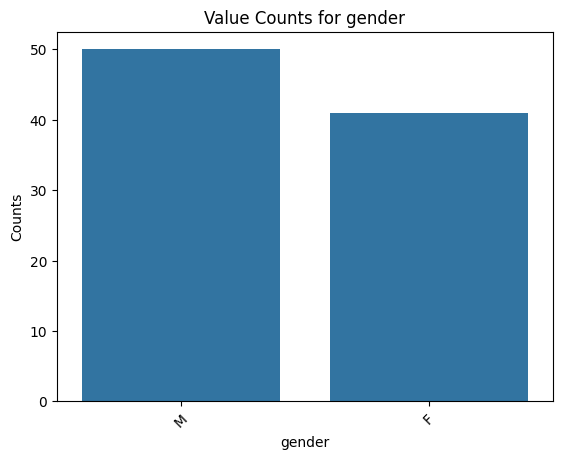

gender
There are 3 unique value(s) in 94 total values. The unique value(s):['M' 'F' nan].
The current datatype is object.
 
Column gender thought to be categorical.
------ Summary Statistics ------
gender
M    50
F    41





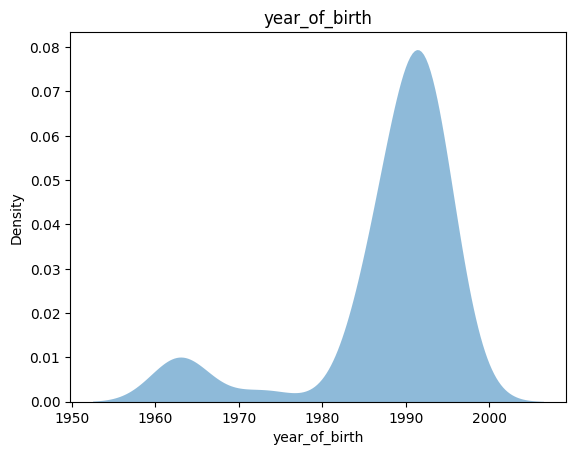

year_of_birth
There are 14 unique value(s) in 94 total values. The first 10 unique value(s):['1986' '1987' '1988' '1993' '1985' '1992' '1996' '1994' '1991' '1990'].
The current datatype is object.
 
Column year_of_birth thought to be numeric.
------ Summary Statistics ------
min: 1963
max: 1996
median: 1991.0





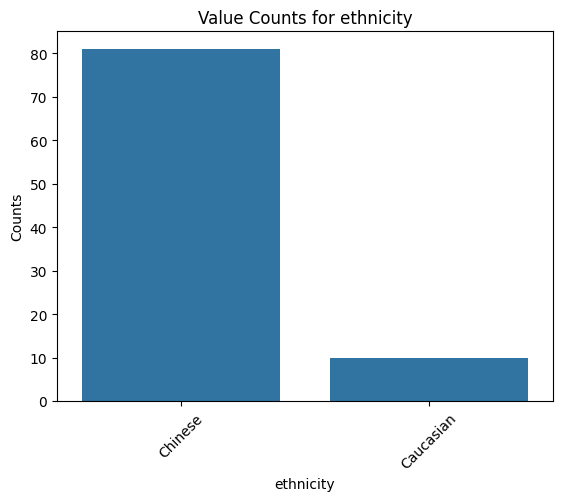

ethnicity
There are 3 unique value(s) in 94 total values. The unique value(s):['Chinese' 'Caucasian' nan].
The current datatype is object.
 
Column ethnicity thought to be categorical.
------ Summary Statistics ------
ethnicity
Chinese      81
Caucasian    10





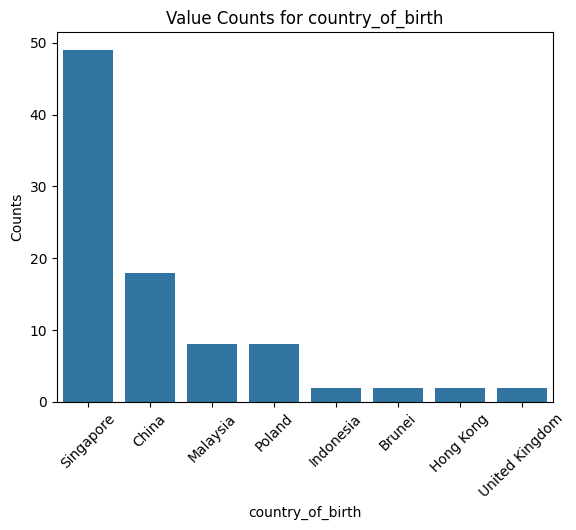

country_of_birth
There are 9 unique value(s) in 94 total values. The unique value(s):['Indonesia' 'Singapore' 'China' 'Malaysia' 'Brunei' 'Hong Kong'
 'United Kingdom' 'Poland' nan].
The current datatype is object.
 
Column country_of_birth thought to be categorical.
------ Summary Statistics ------
country_of_birth
Singapore         49
China             18
Malaysia           8
Poland             8
Indonesia          2
Brunei             2
Hong Kong          2
United Kingdom     2





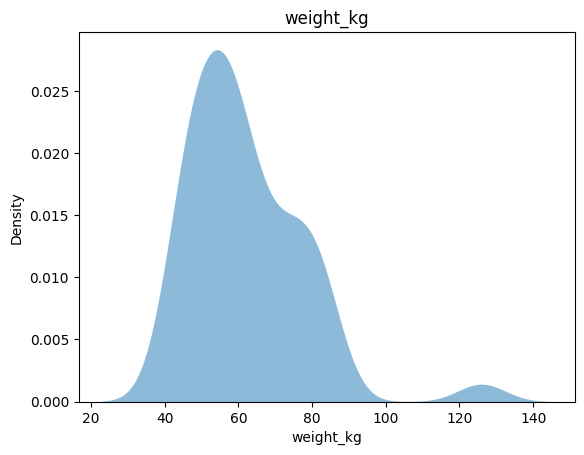

weight_kg
There are 30 unique value(s) in 94 total values. The first 10 unique value(s):['Not collected' '47' '63' '53' '126' '70' '45.9' '50.5' '46' '62'].
The current datatype is object.
 
Column weight_kg thought to be numeric.
------ Summary Statistics ------
min: 42.0
max: 126.0
median: 58.0





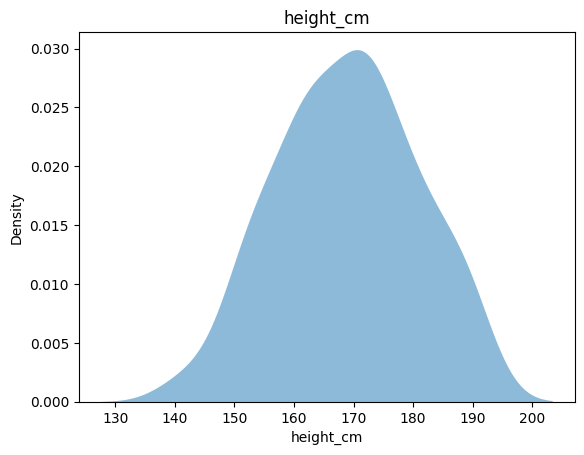

height_cm
There are 27 unique value(s) in 94 total values. The first 10 unique value(s):['Not collected' '178' '163' '162' '174.4' '172' '168' '154' '160' '155'].
The current datatype is object.
 
Column height_cm thought to be numeric.
------ Summary Statistics ------
min: 142.0
max: 189.0
median: 169.0





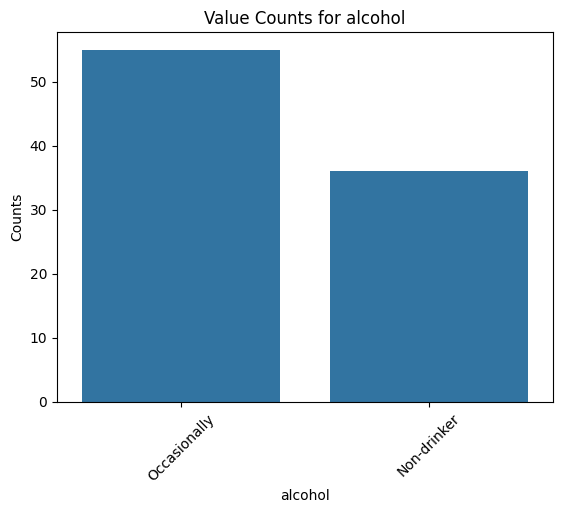

alcohol
There are 3 unique value(s) in 94 total values. The unique value(s):['Non-drinker' 'Occasionally' nan].
The current datatype is object.
 
Column alcohol thought to be categorical.
------ Summary Statistics ------
alcohol
Occasionally    55
Non-drinker     36





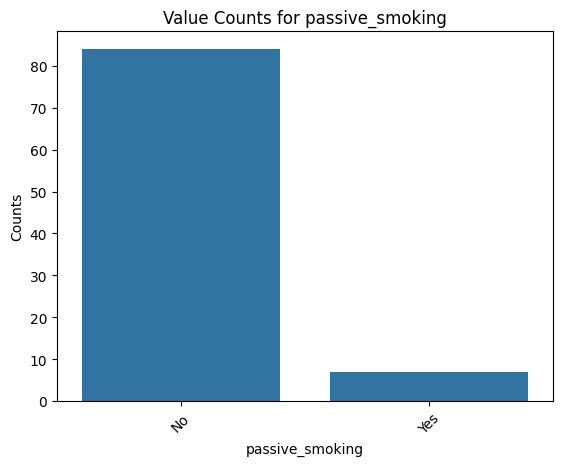

passive_smoking
There are 3 unique value(s) in 94 total values. The unique value(s):['No' 'Yes' nan].
The current datatype is object.
 
Column passive_smoking thought to be categorical.
------ Summary Statistics ------
passive_smoking
No     84
Yes     7





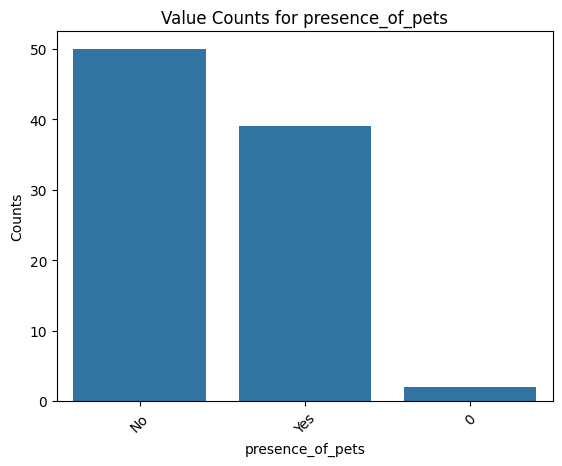

presence_of_pets
There are 4 unique value(s) in 94 total values. The unique value(s):['No' '0' 'Yes' nan].
The current datatype is object.
 
Column presence_of_pets thought to be categorical.
------ Summary Statistics ------
presence_of_pets
No     50
Yes    39
0       2





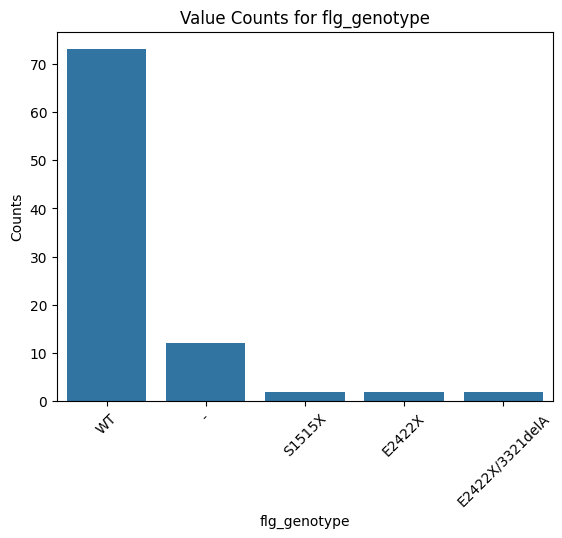

flg_genotype
There are 6 unique value(s) in 94 total values. The unique value(s):['WT' 'S1515X' 'E2422X' 'E2422X/3321delA' '-' nan].
The current datatype is object.
 
Column flg_genotype thought to be categorical.
------ Summary Statistics ------
flg_genotype
WT                 73
-                  12
S1515X              2
E2422X              2
E2422X/3321delA     2





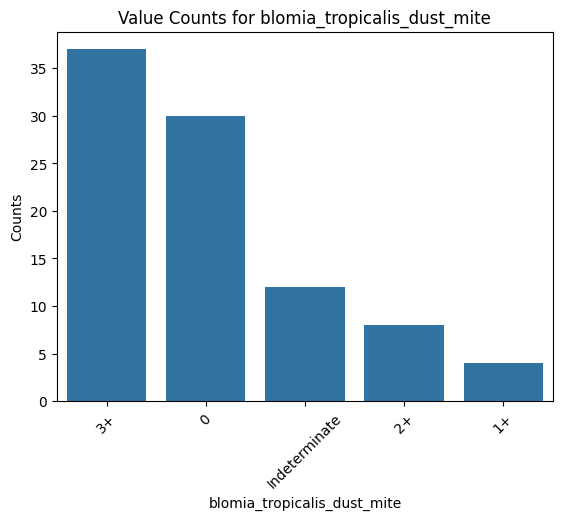

blomia_tropicalis_dust_mite
There are 6 unique value(s) in 94 total values. The unique value(s):['0' '3+' '2+' '1+' 'Indeterminate' nan].
The current datatype is object.
 
Column blomia_tropicalis_dust_mite thought to be categorical.
------ Summary Statistics ------
blomia_tropicalis_dust_mite
3+               37
0                30
Indeterminate    12
2+                8
1+                4





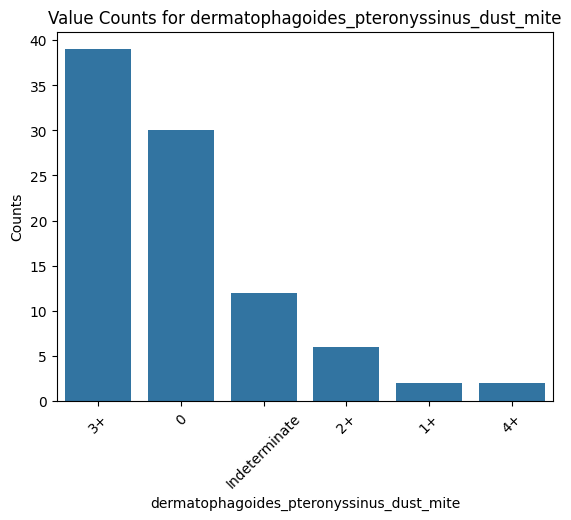

dermatophagoides_pteronyssinus_dust_mite
There are 7 unique value(s) in 94 total values. The unique value(s):['0' '3+' '2+' '1+' '4+' 'Indeterminate' nan].
The current datatype is object.
 
Column dermatophagoides_pteronyssinus_dust_mite thought to be categorical.
------ Summary Statistics ------
dermatophagoides_pteronyssinus_dust_mite
3+               39
0                30
Indeterminate    12
2+                6
1+                2
4+                2





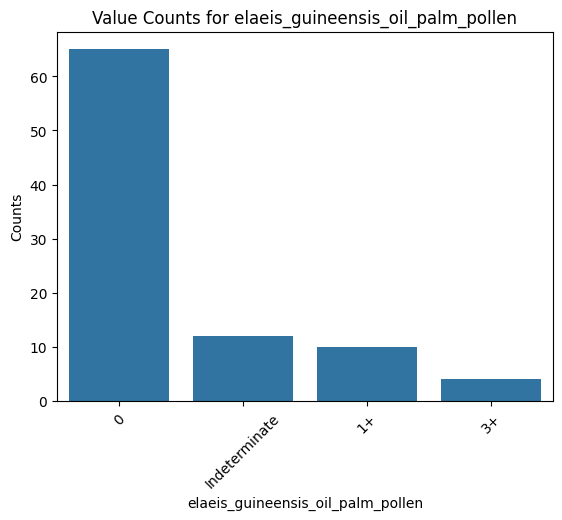

elaeis_guineensis_oil_palm_pollen
There are 5 unique value(s) in 94 total values. The unique value(s):['0' '3+' '1+' 'Indeterminate' nan].
The current datatype is object.
 
Column elaeis_guineensis_oil_palm_pollen thought to be categorical.
------ Summary Statistics ------
elaeis_guineensis_oil_palm_pollen
0                65
Indeterminate    12
1+               10
3+                4





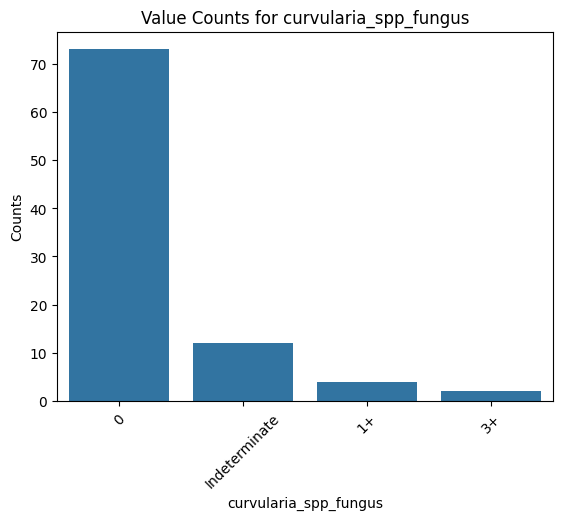

curvularia_spp_fungus
There are 5 unique value(s) in 94 total values. The unique value(s):['0' '1+' '3+' 'Indeterminate' nan].
The current datatype is object.
 
Column curvularia_spp_fungus thought to be categorical.
------ Summary Statistics ------
curvularia_spp_fungus
0                73
Indeterminate    12
1+                4
3+                2





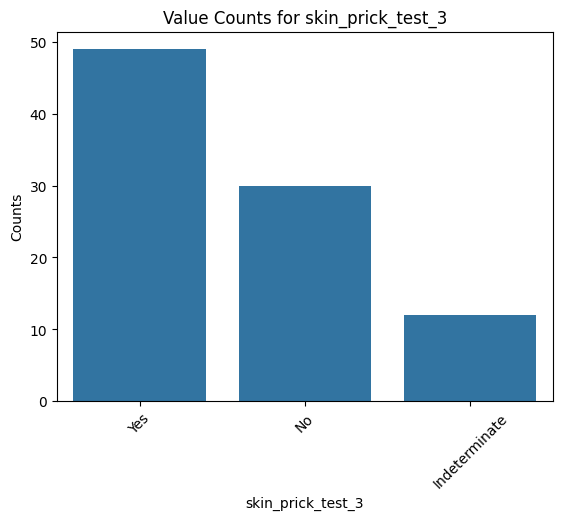

skin_prick_test_3
There are 4 unique value(s) in 94 total values. The unique value(s):['No' 'Yes' 'Indeterminate' nan].
The current datatype is object.
 
Column skin_prick_test_3 thought to be categorical.
------ Summary Statistics ------
skin_prick_test_3
Yes              49
No               30
Indeterminate    12





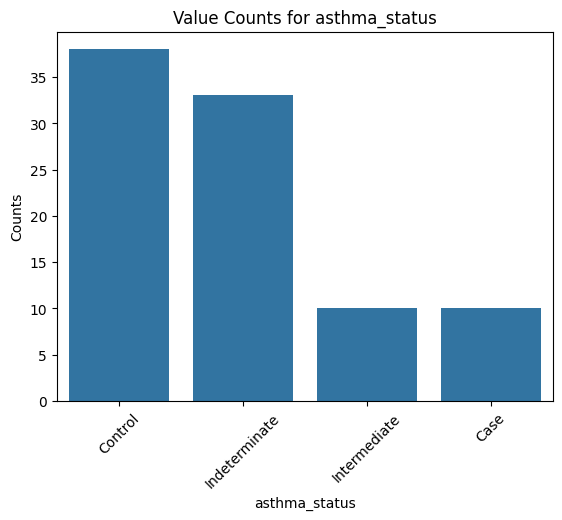

asthma_status
There are 5 unique value(s) in 94 total values. The unique value(s):['Control' 'Indeterminate' 'Intermediate' 'Case' nan].
The current datatype is object.
 
Column asthma_status thought to be categorical.
------ Summary Statistics ------
asthma_status
Control          38
Indeterminate    33
Intermediate     10
Case             10





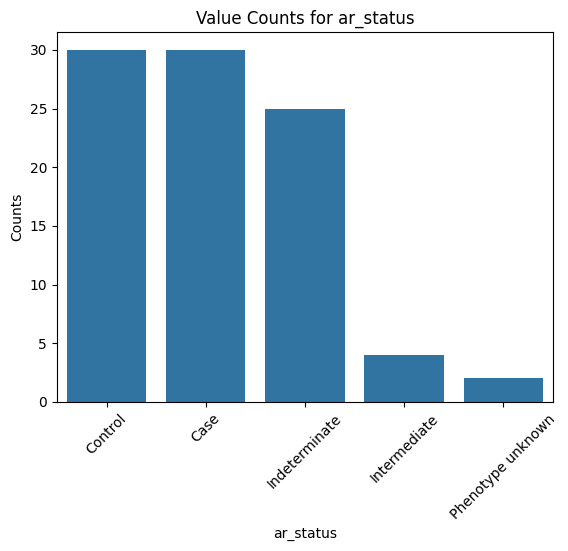

ar_status
There are 6 unique value(s) in 94 total values. The unique value(s):['Control' 'Indeterminate' 'Phenotype unknown' 'Case' 'Intermediate' nan].
The current datatype is object.
 
Column ar_status thought to be categorical.
------ Summary Statistics ------
ar_status
Control              30
Case                 30
Indeterminate        25
Intermediate          4
Phenotype unknown     2





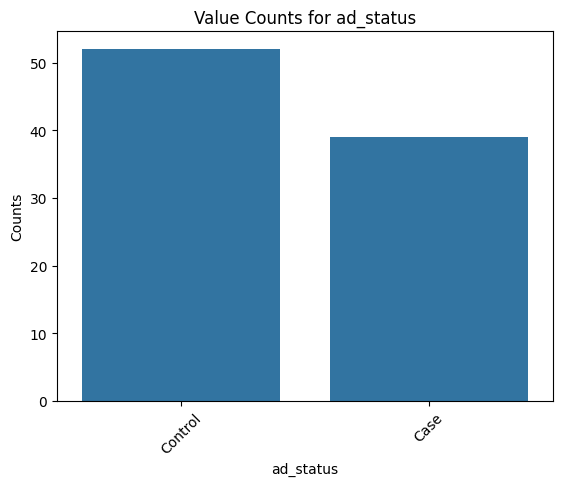

ad_status
There are 3 unique value(s) in 94 total values. The unique value(s):['Control' 'Case' nan].
The current datatype is object.
 
Column ad_status thought to be categorical.
------ Summary Statistics ------
ad_status
Control    52
Case       39





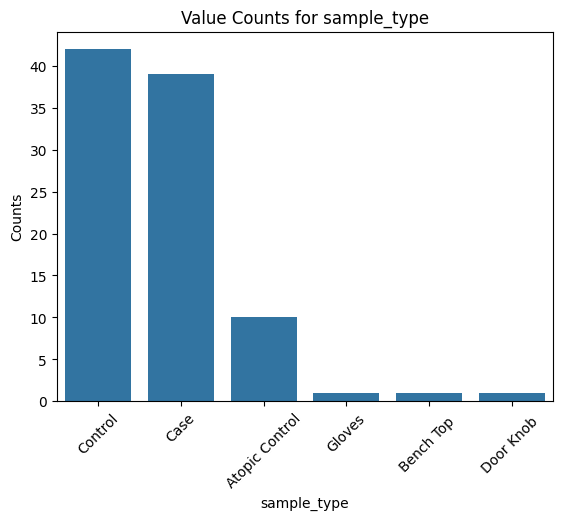

sample_type
There are 6 unique value(s) in 94 total values. The unique value(s):['Control' 'Atopic Control' 'Case' 'Gloves' 'Bench Top ' 'Door Knob '].
The current datatype is object.
 
Column sample_type thought to be categorical.
------ Summary Statistics ------
sample_type
Control           42
Case              39
Atopic Control    10
Gloves             1
Bench Top          1
Door Knob          1





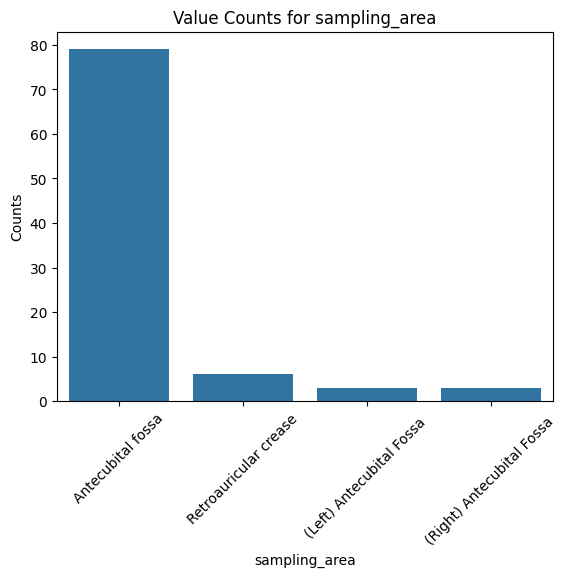

sampling_area
There are 5 unique value(s) in 94 total values. The unique value(s):['Antecubital fossa' 'Retroauricular crease' '(Left) Antecubital Fossa '
 '(Right) Antecubital Fossa ' nan].
The current datatype is object.
 
Column sampling_area thought to be categorical.
------ Summary Statistics ------
sampling_area
Antecubital fossa             79
Retroauricular crease          6
(Left) Antecubital Fossa       3
(Right) Antecubital Fossa      3





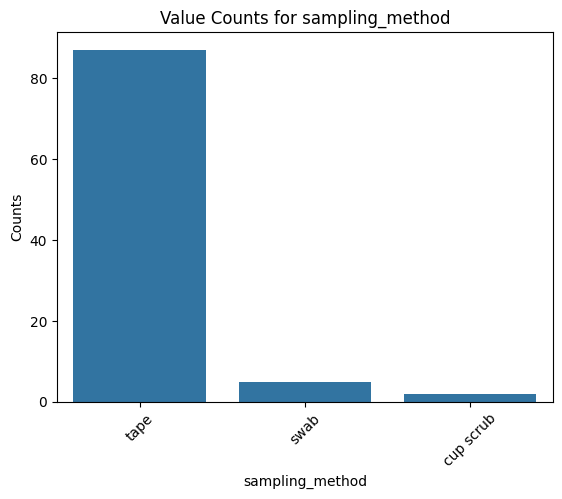

sampling_method
There are 3 unique value(s) in 94 total values. The unique value(s):['tape' 'swab' 'cup scrub'].
The current datatype is object.
 
Column sampling_method thought to be categorical.
------ Summary Statistics ------
sampling_method
tape         87
swab          5
cup scrub     2





In [44]:
summarize()

**Clean up contents of external metadata**

Let's start by checking out the presumed unique identifier.

In [45]:
explore_col("libraryid")

The appropriate Pandas data type for the values in the 'libraryid' column is `category`. 

These values likely represent unique identifiers for different libraries or samples in a dataset, suggesting they may be used to track or categorize data related to various entities or subjects in the study.

Some IDs have trailing spaces (e.g., 'WOS014 ', 'WOS019 ', 'WOS020 ', etc.), which could be considered invalid or unexpected as they may lead to inconsistencies or duplicate entries when comparing or merging data. Additionally, the entry 'WBE025*' includes an asterisk, which could indicate a special condition or be an error that needs to be addressed.


I don't like those trailing spaces.  In fact, I don't want trailing spaces in any column.

In [46]:
find_problem_records()

,libraryid,gender,year_of_birth,ethnicity,country_of_birth,weight_kg,height_cm,alcohol,passive_smoking,presence_of_pets,flg_genotype,blomia_tropicalis_dust_mite,dermatophagoides_pteronyssinus_dust_mite,elaeis_guineensis_oil_palm_pollen,curvularia_spp_fungus,skin_prick_test_3,asthma_status,ar_status,ad_status,sample_type,sampling_area,sampling_method
81,WBS011,M,1989,Caucasian,United Kingdom,72,183,Occasionally,No,No,-,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Control,Control,Control,Control,Retroauricular crease,swab
83,WOS016,M,1963,Caucasian,Poland,82,189,Occasionally,No,No,-,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Control,Control,Control,Control,Retroauricular crease,swab
84,WOS017,M,1963,Caucasian,Poland,82,189,Occasionally,No,No,-,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Control,Control,Control,Control,Retroauricular crease,tape
85,WOS010,M,1963,Caucasian,Poland,82,189,Occasionally,No,No,-,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Control,Control,Control,Control,(Left) Antecubital Fossa,swab
86,WOS012,M,1963,Caucasian,Poland,82,189,Occasionally,No,No,-,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Control,Control,Control,Control,(Left) Antecubital Fossa,tape
87,WOS014,M,1963,Caucasian,Poland,82,189,Occasionally,No,No,-,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Control,Control,Control,Control,(Left) Antecubital Fossa,cup scrub
88,WOS011,M,1963,Caucasian,Poland,82,189,Occasionally,No,No,-,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Control,Control,Control,Control,(Right) Antecubital Fossa,swab
89,WOS013,M,1963,Caucasian,Poland,82,189,Occasionally,No,No,-,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Control,Control,Control,Control,(Right) Antecubital Fossa,tape
90,WOS015,M,1963,Caucasian,Poland,82,189,Occasionally,No,No,-,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Control,Control,Control,Control,(Right) Antecubital Fossa,cup scrub
91,WOS018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gloves,NaN,tape


In [47]:
scrub_problem_records()

Problem records scrubbed.


In [48]:
find_problem_records()

No problem records found.


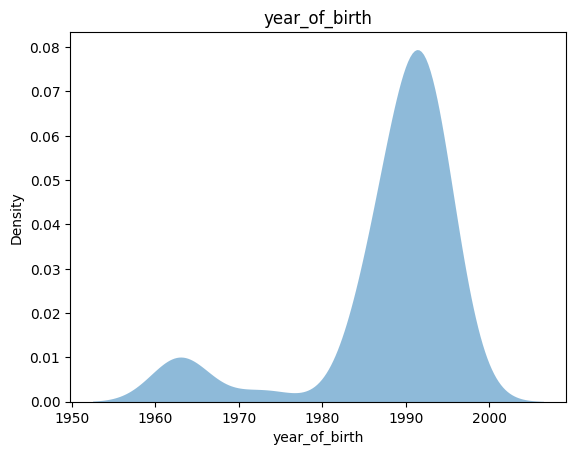

year_of_birth
There are 14 unique value(s) in 94 total values. The first 10 unique value(s):['1986' '1987' '1988' '1993' '1985' '1992' '1996' '1994' '1991' '1990'].
The current datatype is object.
 
Column year_of_birth thought to be numeric.
------ Summary Statistics ------
min: 1963
max: 1996
median: 1991.0





In [49]:
# Summarize a column but now include summary statistics 
# (updated summarize_col that calls summarize_stats) instead of the other way around

summarize_col('year_of_birth')

#### Running only visualizations of columns

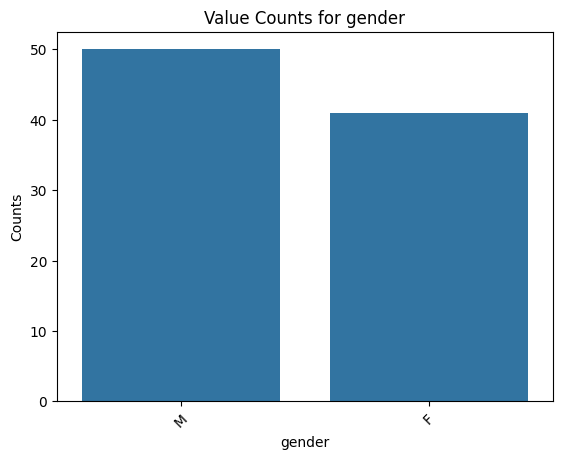

In [50]:
visualize_col('gender')

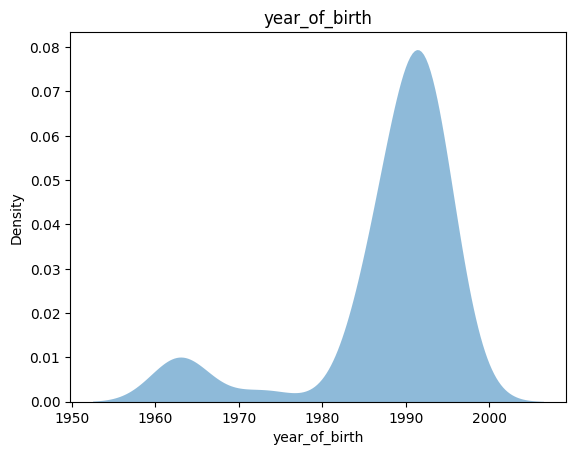

In [51]:
visualize_col('year_of_birth')

In [52]:
g_working_df.rename(columns={'Skin Prick Test (≥3+)': 'Skin_Prick_Test_gte3plus'}, inplace=True)

In [53]:
g_working_df.rename(columns={'Skin Prick Test (≥3+)': 'Skin_Prick_Test_gte3plus'}, inplace=True)

In [55]:
g_working_df.rename(columns={'Skin Prick Test (≥3+)': 'Skin_Prick_Test_gte3plus'}, inplace=True)

Column year_of_birth thought to be numeric.
Column gender thought to be categorical.


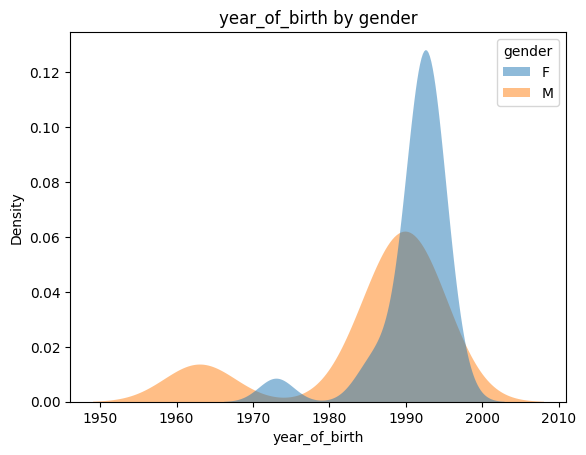

Column weight_kg thought to be numeric.
Column height_cm thought to be numeric.


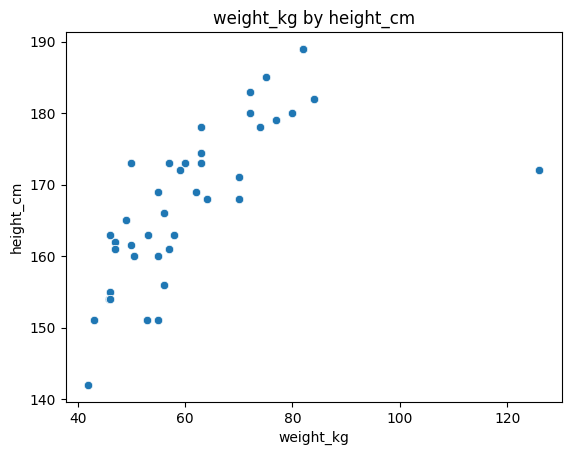

Column gender thought to be categorical.
Column sample_type thought to be categorical.


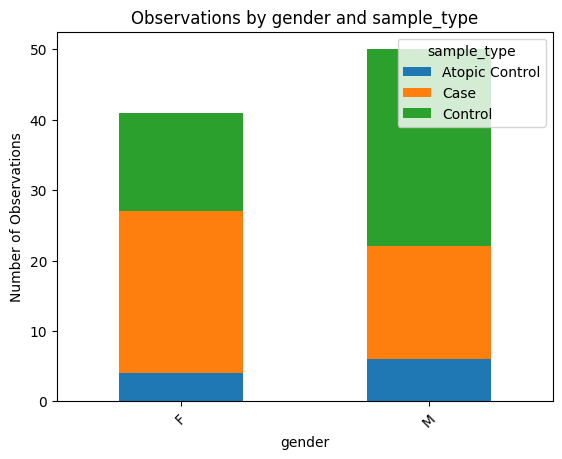

In [54]:
# Visualize two columns at once
visualize_two_cols('year_of_birth', 'gender')
visualize_two_cols('weight_kg', 'height_cm')
visualize_two_cols('gender', 'sample_type')

In [56]:
g_buttons

### QIIMP manipulations

**Set the two qiimp guide columns**

The host shorthand for anything with a gender is human, and for anything else is 'control surface'.

In [50]:
ask(f"Write code to set column '{qiimp.HOSTTYPE_SHORTHAND_KEY}' to 'human' if the 'gender' column is not NaN and to 'control surface' otherwise.")

AttributeError: module 'qiimp' has no attribute 'HOSTTYPE_SHORTHAND_KEY'

In [ ]:
g_working_df['hosttype_shorthand'] = g_working_df['gender'].apply(lambda x: 'human' if pd.notna(x) else 'control surface')

The sample shorthand is based on the 'sampling_area' and the 'sample_type'.  If sampling_area is anything with 'Antecubital fossa' in it, it is 'antecubital fossa'.  If it is 'Retroauricular crease', it is 'retroauricular crease'.  If sampling_srea is NaN, then if sample_type is 'Gloves', the sampletype_shorthand is 'control glove' and otherwise it is 'control surface'. That should cover all the cases.

In [ ]:
g_working_df['sampletype_shorthand'] = g_working_df.apply(
    lambda row: 'antecubital fossa' if pd.notna(row['sampling_area']) and 'antecubital fossa' in str(row['sampling_area']).lower() else
                 'retroauricular crease' if row['sampling_area'] == 'Retroauricular crease' else
                 'control glove' if pd.isna(row['sampling_area']) and row['sample_type'] == 'Gloves' else
                 'control surface' if pd.isna(row['sampling_area']) else
                 None,
    axis=1
)

In [ ]:
g_working_df[g_working_df['sampletype_shorthand'].isna()]

In [ ]:
g_working_df

In [ ]:
ext_metadata_df = g_working_df.copy()

#### Examine the Qiita metadata

In [ ]:
load_df(qiita_metadata_fp, sep_name="tab", override=True)

In [ ]:
summarize()

In [ ]:
explore_col("center_name")

In [ ]:
g_working_df['center_name'] = g_working_df['center_name'].replace('Genome Institrute of Singapore', 'Genome Institute of Singapore')

I know the libraryid column of the external metadata should be matched with the qiita metadata's sample_alias column, so let's take a look at the latter.

In [ ]:
explore_col("sample_alias")

#### Merge the qiita and external metadata

First check for columns that overlap.

In [ ]:
qiimp.find_common_df_cols(g_working_df, ext_metadata_df)

I don't understand how this existing qiita metadata doesn't already have a sample_type column, but I guess it doesn't, so ok; we can go ahead and merge.

In [ ]:
merged_df = qiimp.merge_one_to_one_metadata(g_working_df, ext_metadata_df, "sample_alias", "libraryid", "qiita", "external", "outer")
merged_df

Look for records that occur in the external metadata but not in the qiita metadata:

In [ ]:
merged_df[merged_df["sample_name"].isna()]

Ok, so there's one, and it's the one with the library id that has an asterisk on it (maybe not surprising).  

Conversely, are there records that occur in the qiita metadata but not in the external metadata?

In [ ]:
merged_df[merged_df["libraryid"].isna()]

Hmm, what were the unique libraryids in the external metadata again?

In [ ]:
ext_metadata_df["libraryid"].unique()

In [ ]:
'WBS003' in ext_metadata_df["libraryid"].unique()

Okay, I guess ...

In [ ]:
g_working_df = merged_df.copy()

**Find columns in the external metadata that might be touched by qiimp**

Rename them if they are in danger of being overwritten.

In [ ]:
qiimp_cols = qiimp.get_reserved_cols(g_working_df, {})

In [ ]:
# the qiimp guide columns and the sample_name column are expected by qiimp and won't be altered
expected_shared_cols = [qiimp.HOSTTYPE_SHORTHAND_KEY, qiimp.SAMPLETYPE_SHORTHAND_KEY, "sample_name"]
qiimp.find_common_col_names(g_working_df.columns, qiimp_cols, expected_shared_cols, expected_shared_cols)

In [ ]:
summarize_col("geo_loc_name")

In [ ]:
summarize_col("scientific_name")

In [ ]:
summarize_col("sample_type")

Ok, the 'sample_type' column contains external values worth preserving, so let's rename that column so it is saved.

ask("Write code to rename the 'sample_type' column with the suffix '_external' at the end.")

run_suggestion()

In [ ]:
g_working_df.rename(columns={'sample_type': 'sample_type_external'}, inplace=True)

**Look for standard columns we could fill with the info in the metadata**

In [ ]:
qiimp_cols

In [ ]:
summarize()

Well, we can definitely set the standard 'sex' column from the 'gender' column, and the 'host_weight' from the 'weight_kg' column, and the 'host_height' from the 'height_cm' column. With just the year of birth, we don't have enough to fill in the age, though, and I don't want to try to get host_life_stage based on just the birth year, either.

In [ ]:
g_working_df['sex'] = g_working_df['gender'].apply(qiimp.standardize_input_sex)

In [ ]:
g_working_df['host_weight'] = g_working_df['weight_kg']
g_working_df['host_height'] = g_working_df['height_cm']

**Set TRPCA-specific columns from the metadata**

For this study, they are all conditional on various sample-specific metadata columns.

Wait, first I'm going to remove that record that doesn't have a sample_name, since it can't go into qiita anyway.

In [ ]:
g_working_df.shape

ask("Write code to remove the record that has a NaN 'sample_name' from the dataframe.")

run_suggestion()

In [ ]:
g_working_df.dropna(subset=['sample_name'], inplace=True)

In [ ]:
g_working_df.shape

Ok, lesional status should be not provided for human records and not applicable for others.  There are those samples that we don't have any external metadata for, and they *might* be human, but I don't know; I think I'm going to just treat them as 'not applicable's.

ask("Write code to set the 'lesional_status' column to 'not applicable' if gender is NaN and to 'not provided' otherwise.")

run_suggestion()

In [ ]:
g_working_df['lesional_status'] = g_working_df['gender'].apply(lambda x: 'not applicable' if pd.isna(x) else 'not provided')

In [ ]:
g_working_df

ask("Write code to create a new column 'has_skin_disorder' and set it to 'True' if the the value in 'AD_status' is 'Case', 'False' if 'AD_status' is 'Control', and 'not applicable' if 'AD_status' anything else.")

run_suggestion()

In [ ]:
g_working_df['has_skin_disorder'] = g_working_df['ad_status'].apply(lambda x: True if x == 'Case' else (False if x == 'Control' else 'not applicable'))

ask("Write code to create a new column 'skin_disorder' and set it to 'atopic dermatitis' if 'AD_status' is 'Case' and 'not_applicable' otherwise.")

run_suggestion()

In [ ]:
g_working_df['skin_disorder'] = g_working_df['ad_status'].apply(lambda x: 'atopic dermatitis' if x == 'Case' else 'not_applicable')

#### Run qiimp to extend the metadata with standard column values

In [ ]:
extended_df, validation_msgs = qiimp.get_extended_metadata_from_df_and_yaml(g_working_df, study_config_fp)

In [ ]:
g_working_df.shape

In [ ]:
extended_df.shape

Were there any qc notes or validation messages?

In [ ]:
extended_df[extended_df['qc_note'].notnull() & (extended_df['qc_note'] != '')]

It makes sense that all the ones without libraryids can't have their host and sample types set and thus can't be extended.

In [ ]:
validation_msgs

Well, ok, so there are a bunch of fields that were set to unexpected values (in qiita, before the metadata got to me).  Maybe they should be modified, but I'm not sure what to, so I am going to ignore them and send them back to the stakeholder to deal with.

In [ ]:
qiimp.write_metadata_results(extended_df, validation_msgs, '/Users/abirmingham/Desktop/trpca', "15612_merged_metadata_standardized", remove_internals=True, suppress_empty_fails=True)

In [ ]:
g_working_df.rename(columns={'Skin Prick Test (≥3+)': 'Skin_Prick_Test_gte3plus'}, inplace=True)

## Whisper voice recognition integration

The `Whisper API` from OpenAI is extremely adept at transcribing voice audio recordings. The `sounddevice` API is very simple and just simply records sound to a file that can be processed with Whisper. This needs to be integrated into the previous workflow where buttons can be used to make calls to `record_and_transcribe()`. This also supports different languages and different scripts. A helpful chart of the accuracy of all these can be found here: https://github.com/openai/whisper. Instead of this, we will use speech_recognitions recognize_whisper command, which unfortunately doesn't seem to work as well as using the openai api directly.

In [61]:
import sounddevice as sd
import numpy as np
from scipy.io.wavfile import write
import subprocess
import os
from openai import OpenAI


def record_audio(duration=5, sample_rate=44100, channels=1):
    """Record audio from the microphone."""
    try:
        print("Recording...")
        audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=channels, dtype='float32')
        sd.wait()  # Wait until the recording is complete
        print("Recording finished")
        return audio
    except Exception as e:
        print(f"An error occurred: {e}")

def save_audio_to_wav(filename, audio, sample_rate=44100):
    """Save recorded audio to a WAV file."""
    audio_normalized = np.int16(audio / np.max(np.abs(audio)) * 32767)
    write(filename, sample_rate, audio_normalized)
    # print(f"Audio temporarily saved to {filename}")



In [62]:
def record_audio(duration=5, sample_rate=44100, channels=1):
    """ Record audio from the microphone for <duration> seconds.
        The sampling rate is how frequently the model picks up sound.
        The channel is based on the internal microphone. """
    try:
        print("Recording...")
        audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=channels, dtype='float32')
        sd.wait()  # Wait until the recording is complete
        print("Recording finished.")
        return audio
    except Exception as e:
        print(f"An error occurred: {e}")


def transcribe_audio(f):
    """ Use whisper to transcribe an audio file. """
    client = OpenAI()
    audio_file = open(f, "rb")
    transcription = client.audio.transcriptions.create(
        model="whisper-1", 
        file=audio_file
    )    
    print(transcription.text)

    
def record_and_transcribe(duration=5):
    """ Record audio and transcribe for default 5 seconds. """
    audio_data = record_audio(duration=duration)
    wav_filename = './temp_audio.wav'
    save_audio_to_wav(wav_filename, audio_data)
    transcribe_audio("./temp_audio.wav")


### Examples of how using openai's api directly is better than speech_recognition. Theory is that the microphone is what is wrong.

In [76]:
record_and_transcribe()

Recording...
Recording finished.
Write code to replace all NAND values in a data frame with zero.


In [77]:
record_and_transcribe()

Recording...
Recording finished.
Write code to replace fundam values in the data frame with zero.


In [78]:
record_and_transcribe()

Recording...
Recording finished.
Write code to replace all name values in a data frame with zero.


#### Try with speech_recognition's builtin recognize_whisper

In [80]:
ask('Write code to replace all NAND values in a data frame with the')

g_working_df = g_working_df.fillna('NAND')


In [81]:
ask('Write code to replace all man values in a data frame with zero.')

g_working_df = g_working_df.replace('man', 0)


In [82]:
ask('Right-code to replace on-man values in a data frame with zero.')

g_working_df = g_working_df.replace('non-man', 0)


In [83]:
ask('Write code to replace on NAND values in a D.')

g_working_df = g_working_df.fillna(0)


In [79]:
g_buttons

In [62]:
!pip install SpeechRecognition

In [ ]:
!python3 -m pip install SpeechRecognition[whisper-local]

In [88]:
import os

import speech_recognition as sr

# obtain audio from the microphone
def audio_to_text():
    r = sr.Recognizer()
    with sr.Microphone() as source:
        print("Say something!")
        audio = r.listen(source)
    
    # recognize speech using Whisper API
    try:
        print(f"{r.recognize_whisper(audio)}")
    except sr.RequestError as e:
        print(f"Could not request results from OpenAI Whisper API; {e}")

In [89]:
audio_to_text()

Say something!
 Hello, my name is Danielle Perry.


In [87]:
Categorical

NameError: name 'Categorical' is not defined

In [67]:
!pip install pyaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.1 MB/s eta 0:00:00 MB/s eta 0:00:01
